In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Gathering & Cleaning Data Of Shape Features

Shape Feature Data:¶
Merge multiple files to get shape features data and rename some cultivars

In [2]:
sp_2018= pd.read_csv('table_SP_SHAPE_FEATURES_2018.csv')
sp_2019= pd.read_csv('table_SP_SHAPE_FEATURES_2019.csv')
sp_2020= pd.read_csv('table_SP_SHAPE_FEATURES_2020.csv')
sp_2021= pd.read_csv('table_SP_SHAPE_FEATURES_2021.csv')

shape_feature = ((sp_2018.append(sp_2019)).append(sp_2020)).append(sp_2021)
shape_feature=shape_feature[['Year','Trial_ID','Field_ID','Cultivar','Plot','Location','LWRatio','Curvature']]
shape_feature=shape_feature.dropna(how='any')
shape_feature=shape_feature.iloc[np.where(shape_feature['LWRatio']>=1)]
shape_feature=shape_feature.drop(['LWRatio'],axis=1)

In [3]:
Metadata_2018= pd.read_csv('table_FIELD_METADATA_2018.csv')
Metadata_2019= pd.read_csv('table_FIELD_METADATA_2019.csv')
Metadata_2020= pd.read_csv('table_FIELD_METADATA_2020.csv')
Metadata_2021= pd.read_csv('table_FIELD_METADATA_2021.csv')
Metadata = ((Metadata_2018.append(Metadata_2019)).append(Metadata_2020)).append(Metadata_2021)
Metadata=Metadata.drop(['Lon','Lat'],axis=1)
shape_feature= pd.merge(shape_feature, Metadata,on=["Trial_ID",'Location','Field_ID','Year'])

In [4]:
shape_feature['Cultivar'] = shape_feature.Cultivar.str.replace('_G2', '')
shape_feature["Location"].replace({"Caswell": "Kinston"}, inplace=True)
shape_feature["Location"].replace({"Cunningham": "Kinston"}, inplace=True)
shape_feature["Cultivar"].replace({"NC10-0118M28": "NC10-0118"}, inplace=True)
shape_feature["Cultivar"].replace({"NC09-0122C1": "NC09-0122"}, inplace=True)
shape_feature["Cultivar"].replace({"NC10-0118M25": "NC10-0118"}, inplace=True)
shape_feature["Cultivar"].replace({"B94-14": "Beauregard"}, inplace=True)
shape_feature["Cultivar"].replace({"NC09-0122B3": "NC09-0122"}, inplace=True)
shape_feature["Cultivar"].replace({"NC09-0165C1": "NC09-0165"}, inplace=True)
shape_feature["Cultivar"].replace({"NC05-0198": "Averre"}, inplace=True)
shape_feature=shape_feature.dropna(how='any')

# Select Cultivars

In [5]:
Cultivar = pd.DataFrame(shape_feature.groupby(["Cultivar"]).Trial_ID.nunique().reset_index()).sort_values(by=['Trial_ID'],ascending=False)
Cultivar = Cultivar[Cultivar.Trial_ID != 1]
Cultivar = Cultivar[Cultivar.Trial_ID != 2]
shape_feature =pd.merge(shape_feature,Cultivar,on=['Cultivar'])
shape_feature = shape_feature.rename(index=str, columns={"Trial_ID_y": "Trial_num"})
shape_feature = shape_feature.rename(index=str, columns={"Trial_ID_x": "Trial_ID"})
shape_feature = shape_feature.drop(['Trial_num'],axis=1)

In [6]:
Beauregard=shape_feature.loc[shape_feature['Cultivar'] == 'Beauregard']
Covington=shape_feature.loc[shape_feature['Cultivar'] == 'Covington']
Orleans=shape_feature.loc[shape_feature['Cultivar'] == 'Orleans']
Bellevue=shape_feature.loc[shape_feature['Cultivar'] == 'Bellevue']
Averre=shape_feature.loc[shape_feature['Cultivar'] == 'Averre']
shape_feature_selection=((Beauregard.append(Covington)).append(Orleans)).append(Bellevue).append(Averre)

## Calculate the mean Curvature value for each plot number


In [7]:
df_mean_Cur= pd.DataFrame(shape_feature_selection['Curvature'].groupby([shape_feature_selection['Cultivar'],shape_feature_selection['Trial_ID'],shape_feature_selection['Plot']]).mean()).reset_index()
df_mean_Cur = df_mean_Cur.rename(index=str, columns={"Curvature": "Curvature_mean"})
df_data = pd.merge(shape_feature_selection, df_mean_Cur, on=['Cultivar','Plot','Trial_ID'])


## Variables Analysis

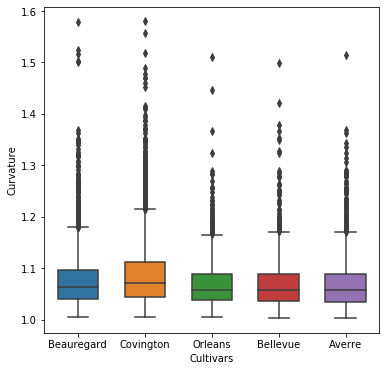

In [8]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(data=df_data, x="Cultivar", y="Curvature",width=0.6)
ax.set_ylabel('Curvature')
ax.set_xlabel('Cultivars')
plt.show()

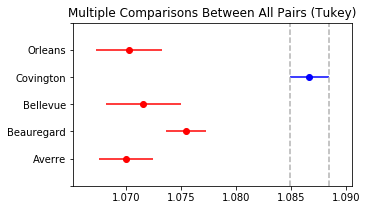

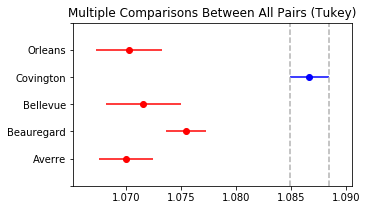

In [9]:
tukey = pairwise_tukeyhsd(endog=df_data['Curvature'],
                          groups=df_data['Cultivar'],
                          alpha=0.05)
tukey.plot_simultaneous(comparison_name = ('Covington'),figsize=(5, 3))


In [10]:
df_data = df_data.drop(['Curvature'],axis=1)
df_data = df_data.drop_duplicates()
df_data =df_data.dropna(how='any')

# Gathering & Cleaning Weather Data

Collect series weather data over certain periods for different variables

In [11]:
path = r'/Users/jin/Desktop/Sweetpotato/shape_feature_prediction_new/Weather_data'
weatherClinton1819 = pd.read_excel(path+'/Clinton_2018_2019.xlsx',skiprows = 12)
weatherKin1819 = pd.read_excel(path+'/Kinston_2018_2019.xlsx',skiprows = 12)
weatherClinton20_21 = pd.read_excel(path+'/Clinton_2020_2021.xlsx',skiprows = 12)
weatherKin20_21 = pd.read_excel(path+'/Kinston_2020_2021.xlsx',skiprows = 12)
weatherClinton=pd.concat([weatherClinton1819,weatherClinton20_21])
weatherKin=pd.concat([weatherKin1819,weatherKin20_21])
weatherClinton=weatherClinton[['Date','Average Air Temperature (F)','Maximum Air Temperature (F)','Minimum Air Temperature (F)','Total Precipitation (in)','Average Solar Radiation (W/m2)']]
weatherKin=weatherKin[['Date','Average Air Temperature (F)','Maximum Air Temperature (F)','Minimum Air Temperature (F)','Total Precipitation (in)','Average Solar Radiation (W/m2)']]
T_base=60

In [12]:
loc=np.where(weatherClinton == 'QCF')
for i in range(np.shape(loc)[1]):
    weatherClinton.iloc[loc[0][i],loc[1][i]]=weatherClinton.iloc[loc[0][i]-1,loc[1][i]]
loc=np.where(weatherKin == 'QCF')
for i in range(np.shape(loc)[1]):
    weatherKin.iloc[loc[0][i],loc[1][i]]=weatherKin.iloc[loc[0][i]-1,loc[1][i]]

In [13]:
weatherClinton['Maximum Air Temperature (F)']=weatherClinton['Maximum Air Temperature (F)'].astype('float64')
weatherClinton['Minimum Air Temperature (F)']=weatherClinton['Minimum Air Temperature (F)'].astype('float64')
weatherClinton['GDDdaily']=(weatherClinton['Maximum Air Temperature (F)']+weatherClinton['Minimum Air Temperature (F)'])/2-T_base
for i in range(len(weatherClinton)):
    if weatherClinton['GDDdaily'].iloc[i]< 0:
        weatherClinton['GDDdaily'].iloc[i]= 0


/Users/jin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
weatherKin['Maximum Air Temperature (F)']=weatherKin['Maximum Air Temperature (F)'].astype('float64')
weatherKin['Minimum Air Temperature (F)']=weatherKin['Minimum Air Temperature (F)'].astype('float64')
weatherKin['GDDdaily']=(weatherKin['Maximum Air Temperature (F)']+weatherKin['Minimum Air Temperature (F)'])/2-T_base
for i in range(len(weatherKin)):
    if weatherKin['GDDdaily'].iloc[i]< 0:
        weatherKin['GDDdaily'].iloc[i]= 0


In [15]:
weatherClinton=weatherClinton.drop(['Maximum Air Temperature (F)'],axis=1)
weatherClinton=weatherClinton.drop(['Minimum Air Temperature (F)'],axis=1)
weatherClinton = weatherClinton.rename(index=str, columns={"Average Air Temperature (F)": "Temp"})
weatherClinton= weatherClinton.rename(index=str, columns={"Average Solar Radiation (W/m2)": "Radiation"})
weatherClinton=weatherClinton.rename(index=str, columns={"Total Precipitation (in)": "Precipitation"})
weatherClinton=weatherClinton.rename(index=str, columns={"GDDdaily": "GDD"})
weatherClinton_temp=weatherClinton[['Date','Temp']]
weatherClinton_prep=weatherClinton[['Date','Precipitation']]
weatherClinton_solar=weatherClinton[['Date','Radiation']]
weatherClinton_GDD=weatherClinton[['Date','GDD']]

In [16]:
weatherKin=weatherKin.drop(['Maximum Air Temperature (F)'],axis=1)
weatherKin=weatherKin.drop(['Minimum Air Temperature (F)'],axis=1)
weatherKin = weatherKin.rename(index=str, columns={"Average Air Temperature (F)": "Temp"})
weatherKin= weatherKin.rename(index=str, columns={"Average Solar Radiation (W/m2)": "Radiation"})
weatherKin= weatherKin.rename(index=str, columns={"Total Precipitation (in)": "Precipitation"})
weatherKin=weatherClinton.rename(index=str, columns={"GDDdaily": "GDD"})
weatherKin_temp=weatherKin[['Date','Temp']]
weatherKin_prep=weatherKin[['Date','Precipitation']]
weatherKin_solar=weatherKin[['Date','Radiation']]
weatherKin_GDD=weatherKin[['Date','GDD']]

In [17]:
g = shape_feature_selection.groupby(["Location"])
groups_clin = g.get_group((list(g.groups)[0])).groupby(['Planted','Harvested'])
groups_kin = g.get_group((list(g.groups)[1])).groupby(['Planted','Harvested'])

### Clinton

In [18]:
import datetime
start_date_temp ={}
end_date_temp={}
Planted_temp ={}
Harvested_temp={}
for i in range(len(groups_clin)):
    group_clin=groups_clin.get_group((list(groups_clin.groups)[i]))
    date1=group_clin['Planted']
    Planted_temp[i]=date1.iloc[0]
    start_date_temp[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=0)
    start_date_temp[i]= datetime.datetime.strftime(start_date_temp[i], '%Y-%m-%d')
    end_date_temp[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=72)
    end_date_temp[i]= datetime.datetime.strftime(end_date_temp[i], '%Y-%m-%d')

In [19]:
start_date_prep ={}
end_date_prep={}
Planted_prep ={}
Harvested_prep={}
for i in range(len(groups_clin)):
    group_clin=groups_clin.get_group((list(groups_clin.groups)[i]))
    date1=group_clin['Planted']
    Planted_prep[i]=date1.iloc[0]
    start_date_prep[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=3)
    start_date_prep[i]= datetime.datetime.strftime(start_date_prep[i], '%Y-%m-%d')
    end_date_prep[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=70)
    end_date_prep[i]= datetime.datetime.strftime(end_date_prep[i], '%Y-%m-%d')

In [20]:
start_date_solar ={}
end_date_solar={}
Planted_solar ={}
Harvested_solar={}
for i in range(len(groups_clin)):
    group_clin=groups_clin.get_group((list(groups_clin.groups)[i]))
    date1=group_clin['Planted']
    Planted_solar[i]=date1.iloc[0]
    start_date_solar[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=0)
    start_date_solar[i]= datetime.datetime.strftime(start_date_solar[i], '%Y-%m-%d')
    end_date_solar[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=33)
    end_date_solar[i]= datetime.datetime.strftime(end_date_solar[i], '%Y-%m-%d')

In [21]:
start_date_GDD ={}
end_date_GDD={}
Planted_GDD ={}
Harvested_GDD={}
for i in range(len(groups_clin)):
    group_clin=groups_clin.get_group((list(groups_clin.groups)[i]))
    date1=group_clin['Planted']
    Planted_GDD[i]=date1.iloc[0]
    start_date_GDD[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=0)
    start_date_GDD[i]= datetime.datetime.strftime(start_date_GDD[i], '%Y-%m-%d')
    end_date_GDD[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=73)
    end_date_GDD[i]= datetime.datetime.strftime(end_date_GDD[i], '%Y-%m-%d')

In [22]:
mask_temp={}
time_seris_weather_temp={}
weather_clinton_temp=[]
for i in range(len(groups_clin)):
    mask_temp = (weatherClinton_temp['Date'] >= start_date_temp[i]) & (weatherClinton_temp['Date'] <= end_date_temp[i])
    weather = weatherClinton_temp.loc[mask_temp] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_temp[i])- datetime.timedelta(days=0)
    df_weather.to_csv(r'df_weather_daily_clinton_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_clinton_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_temp[i]=weather_daily
    weather_clinton_temp = pd.concat(time_seris_weather_temp)
weather_clinton_temp['Location']='Clinton'

weather_clinton_temp=weather_clinton_temp.drop_duplicates()
weather_clinton_temp=weather_clinton_temp.sort_values(by=['Planted'])

In [23]:
mask_prep={}
time_seris_weather_prep={}
weather_clinton_prep=[]
for i in range(len(groups_clin)):
    mask_prep = (weatherClinton_prep['Date'] >= start_date_prep[i]) & (weatherClinton_prep['Date'] <= end_date_prep[i])
    weather = weatherClinton_prep.loc[mask_prep] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_prep[i])- datetime.timedelta(days=3)
    df_weather.to_csv(r'df_weather_daily_clinton_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_clinton_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_prep[i]=weather_daily
    weather_clinton_prep = pd.concat(time_seris_weather_prep)
weather_clinton_prep['Location']='Clinton'

weather_clinton_prep=weather_clinton_prep.drop_duplicates()
weather_clinton_prep=weather_clinton_prep.sort_values(by=['Planted'])

In [24]:
mask_solar={}
time_seris_weather_solar={}
weather_clinton_solar=[]
for i in range(len(groups_clin)):
    mask_solar = (weatherClinton_solar['Date'] >= start_date_solar[i]) & (weatherClinton_solar['Date'] <= end_date_solar[i])
    weather = weatherClinton_solar.loc[mask_solar] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_solar[i])- datetime.timedelta(days=0)
    df_weather.to_csv(r'df_weather_daily_clinton_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_clinton_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_solar[i]=weather_daily
    weather_clinton_solar = pd.concat(time_seris_weather_solar)
weather_clinton_solar['Location']='Clinton'

weather_clinton_solar=weather_clinton_solar.drop_duplicates()
weather_clinton_solar=weather_clinton_solar.sort_values(by=['Planted'])

In [25]:
mask_GDD={}
time_seris_weather_GDD={}
weather_clinton_GDD=[]
for i in range(len(groups_clin)):
    mask_GDD = (weatherClinton_GDD['Date'] >= start_date_GDD[i]) & (weatherClinton_GDD['Date'] <= end_date_GDD[i])
    weather = weatherClinton_GDD.loc[mask_GDD] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_GDD[i])- datetime.timedelta(days=0)
    df_weather.to_csv(r'df_weather_daily_clinton_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_clinton_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_GDD[i]=weather_daily
    weather_clinton_GDD = pd.concat(time_seris_weather_GDD)
weather_clinton_GDD['Location']='Clinton'

weather_clinton_GDD=weather_clinton_GDD.drop_duplicates()
weather_clinton_GDD=weather_clinton_GDD.sort_values(by=['Planted'])

In [26]:
## Change columns' name
temp = weather_clinton_temp.iloc[:, 0:73]
temp.columns = [f'Temp_{n}' for n in range(1, 74)]
weather_clinton_temp=pd.concat([temp,weather_clinton_temp.iloc[:, 73:75]], axis = 1)
temp = weather_clinton_GDD.iloc[:, 0:74]
temp.columns = [f'GDD_{n}' for n in range(1, 75)]
weather_clinton_GDD=pd.concat([temp,weather_clinton_GDD.iloc[:, 74:76]], axis = 1)
temp = weather_clinton_solar.iloc[:, 0:34]
temp.columns = [f'Radiation_{n}' for n in range(1, 35)]
weather_clinton_solar=pd.concat([temp,weather_clinton_solar.iloc[:, 34:36]], axis = 1)
temp = weather_clinton_prep.iloc[:, 0:68]
temp.columns = [f'Precipitation_{n}' for n in range(1, 69)]
weather_clinton_prep=pd.concat([temp,weather_clinton_prep.iloc[:, 68:70]], axis = 1)

In [27]:
weather_clinton= pd.merge(weather_clinton_temp,weather_clinton_prep, on=['Planted','Location'])
weather_clinton= pd.merge(weather_clinton,weather_clinton_solar, on=['Planted','Location'])
weather_clinton= pd.merge(weather_clinton,weather_clinton_GDD, on=['Planted','Location'])

### Kinston


In [28]:
start_date_temp ={}
end_date_temp={}
Planted_temp ={}
Harvested_temp={}
for i in range(len(groups_kin)):
    group_kin=groups_kin.get_group((list(groups_kin.groups)[i]))
    date1=group_kin['Planted']
    Planted_temp[i]=date1.iloc[0]
    start_date_temp[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=0)
    start_date_temp[i]= datetime.datetime.strftime(start_date_temp[i], '%Y-%m-%d')
    end_date_temp[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=72)
    end_date_temp[i]= datetime.datetime.strftime(end_date_temp[i], '%Y-%m-%d')

In [29]:
start_date_prep ={}
end_date_prep={}
Planted_prep ={}
Harvested_prep={}
for i in range(len(groups_kin)):
    group_kin=groups_kin.get_group((list(groups_kin.groups)[i]))
    date1=group_kin['Planted']
    Planted_prep[i]=date1.iloc[0]
    start_date_prep[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=3)
    start_date_prep[i]= datetime.datetime.strftime(start_date_prep[i], '%Y-%m-%d')
    end_date_prep[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=70)
    end_date_prep[i]= datetime.datetime.strftime(end_date_prep[i], '%Y-%m-%d')

In [30]:
start_date_solar ={}
end_date_solar={}
Planted_solar ={}
Harvested_solar={}
for i in range(len(groups_kin)):
    group_kin=groups_kin.get_group((list(groups_kin.groups)[i]))
    date1=group_kin['Planted']
    Planted_solar[i]=date1.iloc[0]
    start_date_solar[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=0)
    start_date_solar[i]= datetime.datetime.strftime(start_date_solar[i], '%Y-%m-%d')
    end_date_solar[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=33)
    end_date_solar[i]= datetime.datetime.strftime(end_date_solar[i], '%Y-%m-%d')

In [31]:
start_date_GDD ={}
end_date_GDD={}
Planted_GDD ={}
Harvested_GDD={}
for i in range(len(groups_kin)):
    group_kin=groups_kin.get_group((list(groups_kin.groups)[i]))
    date1=group_kin['Planted']
    Planted_GDD[i]=date1.iloc[0]
    start_date_GDD[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=0)
    start_date_GDD[i]= datetime.datetime.strftime(start_date_GDD[i], '%Y-%m-%d')
    end_date_GDD[i]=pd.to_datetime(date1.iloc[0]) + datetime.timedelta(days=73)
    end_date_GDD[i]= datetime.datetime.strftime(end_date_GDD[i], '%Y-%m-%d')

In [32]:
mask_temp={}
time_seris_weather_temp={}
weather_kinston_temp=[]
for i in range(len(groups_kin)):
    mask_temp = (weatherKin_temp['Date'] >= start_date_temp[i]) & (weatherKin_temp['Date'] <= end_date_temp[i])
    weather = weatherKin_temp.loc[mask_temp] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_temp[i])- datetime.timedelta(days=0)
    df_weather.to_csv(r'df_weather_daily_kin_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_kin_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_temp[i]=weather_daily
    weather_kinston_temp = pd.concat(time_seris_weather_temp)
weather_kinston_temp['Location']='Kinston'

weather_kinston_temp=weather_kinston_temp.drop_duplicates()
weather_kinston_temp=weather_kinston_temp.sort_values(by=['Planted'])

In [33]:
mask_prep={}
time_seris_weather_prep={}
weather_kinston_prep=[]
for i in range(len(groups_kin)):
    mask_prep = (weatherKin_prep['Date'] >= start_date_prep[i]) & (weatherKin_prep['Date'] <= end_date_prep[i])
    weather = weatherKin_prep.loc[mask_prep] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_prep[i])- datetime.timedelta(days=3)
    df_weather.to_csv(r'df_weather_daily_kin_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_kin_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_prep[i]=weather_daily
    weather_kinston_prep = pd.concat(time_seris_weather_prep)
weather_kinston_prep['Location']='Kinston'

weather_kinston_prep=weather_kinston_prep.drop_duplicates()
weather_kinston_prep=weather_kinston_prep.sort_values(by=['Planted'])


In [34]:
mask_solar={}
time_seris_weather_solar={}
weather_kinston_solar=[]
for i in range(len(groups_kin)):
    mask_solar = (weatherKin_solar['Date'] >= start_date_solar[i]) & (weatherKin_solar['Date'] <= end_date_solar[i])
    weather = weatherKin_solar.loc[mask_solar] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_solar[i])- datetime.timedelta(days=0)
    df_weather.to_csv(r'df_weather_daily_kin_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_kin_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_solar[i]=weather_daily
    weather_kinston_solar = pd.concat(time_seris_weather_solar)
weather_kinston_solar['Location']='Kinston'

weather_kinston_solar=weather_kinston_solar.drop_duplicates()
weather_kinston_solar=weather_kinston_solar.sort_values(by=['Planted'])

In [35]:
mask_GDD={}
time_seris_weather_GDD={}
weather_kinston_GDD=[]
for i in range(len(groups_kin)):
    mask_GDD = (weatherKin_GDD['Date'] >= start_date_GDD[i]) & (weatherKin_GDD['Date'] <= end_date_GDD[i])
    weather = weatherKin_GDD.loc[mask_GDD] 
    weather=weather.drop(['Date'],axis=1)
    
    weather = weather.unstack().to_frame().T
    df_weather=weather
    df_weather['Planted']=pd.to_datetime(start_date_GDD[i])- datetime.timedelta(days=0)
    df_weather.to_csv(r'df_weather_daily_kin_new.csv', index = False)
    weather_daily= pd.read_csv('df_weather_daily_kin_new.csv')
    weather_daily=weather_daily.drop(weather_daily.index[0])
    time_seris_weather_GDD[i]=weather_daily
    weather_kinston_GDD = pd.concat(time_seris_weather_GDD)
weather_kinston_GDD['Location']='Kinston'

weather_kinston_GDD=weather_kinston_GDD.drop_duplicates()
weather_kinston_GDD=weather_kinston_GDD.sort_values(by=['Planted'])

In [36]:
## Change columns' name
temp = weather_kinston_temp.iloc[:, 0:73]
temp.columns = [f'Temp_{n}' for n in range(1, 74)]
weather_kinston_temp=pd.concat([temp,weather_kinston_temp.iloc[:, 73:75]], axis = 1)
temp = weather_kinston_GDD.iloc[:, 0:74]
temp.columns = [f'GDD_{n}' for n in range(1, 75)]
weather_kinston_GDD=pd.concat([temp,weather_kinston_GDD.iloc[:, 74:76]], axis = 1)
temp = weather_kinston_solar.iloc[:, 0:34]
temp.columns = [f'Radiation_{n}' for n in range(1, 35)]
weather_kinston_solar=pd.concat([temp,weather_kinston_solar.iloc[:, 34:36]], axis = 1)
temp = weather_kinston_prep.iloc[:, 0:68]
temp.columns = [f'Precipitation_{n}' for n in range(1, 69)]
weather_kinston_prep=pd.concat([temp,weather_kinston_prep.iloc[:, 68:70]], axis = 1)


In [37]:
weather_kinston= pd.merge(weather_kinston_temp,weather_kinston_prep, on=['Planted','Location'])
weather_kinston= pd.merge(weather_kinston,weather_kinston_solar, on=['Planted','Location'])
weather_kinston= pd.merge(weather_kinston,weather_kinston_GDD, on=['Planted','Location'])

In [38]:
weather_series = pd.concat([weather_clinton, weather_kinston])
weather_series=weather_series.drop_duplicates()
weather_series['Planted']=weather_series['Planted'].astype('datetime64')
weather_series=weather_series.reset_index()
weather_series=weather_series.drop(['index'],axis=1)


In [39]:
df_data['Planted']=pd.to_datetime(df_data['Planted'])
df_data['Harvested']=pd.to_datetime(df_data['Harvested'])
df_data['Trial_ID']=df_data['Trial_ID'].astype('str')
df_mean_data = pd.merge(df_data, weather_series, on=['Planted','Location'])
df_mean_data['Plot']=df_mean_data['Plot'].astype('float64')

# Gathering & Cleaning Field Data


In [41]:
field_practice = pd.read_csv(path+'/SWEETPOTATO_Field_Data_Final.csv')
GPS_Clinton_1819 = pd.read_excel('Clinton_Plots_GPS_18_19.xlsx')
GPS_Clinton_1819['Location'] = 'Clinton'
GPS_Cunningham_1819 = pd.read_excel('Cunningham_Plots_GPS_18_19.xlsx')
GPS_Cunningham_1819['Location'] = 'Cunningham'
GPS_Caswell_1819 = pd.read_excel('Caswell_Plots_GPS_19.xlsx')
GPS_Caswell_1819=GPS_Caswell_1819.rename(index=str, columns={"Field_area": "Area_acres"})
GPS_Caswell_1819['Location'] = 'Caswell'
GPS_1819 = pd.concat([GPS_Clinton_1819, GPS_Cunningham_1819,GPS_Caswell_1819])
GPS_1819 = GPS_1819.drop_duplicates()
GPS_1819 =GPS_1819[['Trial_ID','PlotNum','Centroid_x_coord','Centroid_y_coord']]

In [42]:
Cunningham= pd.read_excel('Plots_Cunningham_TableToExcel.xlsx')
Caswell= pd.read_excel('Plots_Caswell.xls')
Clinton= pd.read_excel('Plots_Clinton.xls')
Cunningham=Cunningham[['Trial_ID','PlotNum','Latitude','Longitude']]
Caswell=Caswell[['Trial_ID','PlotNum','Latitude','Longitude']]
Clinton=Clinton[['Trial_ID','PlotNum','Latitude','Longitude']]

In [43]:
plots_GPS = ((Cunningham.append(Caswell)).append(Clinton))
plots_GPS = ((Cunningham.append(Caswell)).append(Clinton))
plots_GPS['Trial_ID'].replace(' ', np.nan, inplace=True)
plots_GPS['PlotNum'].replace(' ', np.nan, inplace=True)
plots_GPS=plots_GPS.dropna(how='any')
plots_GPS=plots_GPS.rename(index=str, columns={"PlotNum": "Plot"})
plots_GPS['Plot']=plots_GPS['Plot'].astype('float64')
plots_GPS['Trial_ID']=plots_GPS['Trial_ID'].astype('str')

In [44]:
plots_GPS['x'] = np.cos(plots_GPS['Latitude']) * np.cos(plots_GPS['Longitude'])
plots_GPS['y'] = np.cos(plots_GPS['Latitude']) * np.sin(plots_GPS['Longitude'])
plots_GPS['z'] = np.sin(plots_GPS['Longitude'])
plots_GPS =plots_GPS[['Trial_ID','Plot','x','y','z']]

In [45]:
plots_GPS['Trial_ID']=plots_GPS['Trial_ID'].replace([' 21PRE20024CUNA03'], ['21PRE20024CUNA03'])
plots_GPS['Trial_ID']=plots_GPS['Trial_ID'].replace(['21PURS0036CUNA03zz'], ['21PURS0036CUNA03'])
plots_GPS['Trial_ID']=plots_GPS['Trial_ID'].replace([' 21SPEC0024CUNA03'], ['21SPEC0024CUNA03']) 

In [46]:
# GPS location correct

A01=df_mean_data.iloc[np.where(df_mean_data['Field_ID']=='A01')]
A01['Plot']=A01['Plot'].astype(str).str[:-2].astype(int)+19000
df_mean_data['Plot'].iloc[np.where(df_mean_data['Field_ID']=='A01')]=A01['Plot']

PRE20024CUNA03=df_mean_data.iloc[np.where(df_mean_data['Trial_ID']=='21PRE20024CUNA03')]
PRE20024CUNA03['Plot']=PRE20024CUNA03['Plot'].astype(str).str[:-2].astype(int)+16400
df_mean_data['Plot'].iloc[np.where(df_mean_data['Trial_ID']=='21PRE20024CUNA03')]=PRE20024CUNA03['Plot']

PRE30024CUNA03=df_mean_data.iloc[np.where(df_mean_data['Trial_ID']=='21PRE30024CUNA03')]
PRE30024CUNA03['Plot']=PRE30024CUNA03['Plot'].astype(str).str[:-2].astype(int)+16400
df_mean_data['Plot'].iloc[np.where(df_mean_data['Trial_ID']=='21PRE30024CUNA03')]=PRE30024CUNA03['Plot']

PURS0036CUNA03=df_mean_data.iloc[np.where(df_mean_data['Trial_ID']=='21PURS0036CUNA03')]
PURS0036CUNA03['Plot']=PURS0036CUNA03['Plot'].astype(str).str[:-2].astype(int)+14800
df_mean_data['Plot'].iloc[np.where(df_mean_data['Trial_ID']=='21PURS0036CUNA03')]=PURS0036CUNA03['Plot']

/Users/jin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/jin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [48]:
## Rename columns
field_practice=field_practice.rename(index=str, columns={"Pre_Plant_Fert": "Fert_Pre_Plant"})
field_practice=field_practice.rename(index=str, columns={"Pre_Plant_Irrigation": "Irrigation_Pre_Plant"})
field_practice=field_practice.rename(index=str, columns={"Pre_Plant_Pestic": "Pestic_Pre_Plant"})

field_practice=field_practice.rename(index=str, columns={"GS1_Fert": "Fert_GS1"})
field_practice=field_practice.rename(index=str, columns={"GS2_Fert": "Fert_GS2"})
field_practice=field_practice.rename(index=str, columns={"GS3_Fert": "Fert_GS3"})

field_practice=field_practice.rename(index=str, columns={"GS1_Irrigation": "Irrigation_GS1"})
field_practice=field_practice.rename(index=str, columns={"GS2_Irrigation": "Irrigation_GS2"})
field_practice=field_practice.rename(index=str, columns={"GS3_Irrigation": "Irrigation_GS3"})

field_practice=field_practice.rename(index=str, columns={"GS1_Pestic": "Pestic_GS1"})
field_practice=field_practice.rename(index=str, columns={"GS2_Pestic": "Pestic_GS2"})
field_practice=field_practice.rename(index=str, columns={"GS3_Pestic": "Pestic_GS3"})


In [49]:
df_mean_data['Trial_ID']=df_mean_data['Trial_ID'].astype('str')
field_practice['Trial_ID']=field_practice['Trial_ID'].astype('str')
df_mean_data1 = pd.merge(df_mean_data, field_practice, on=['Trial_ID'])

In [50]:
df_mean_data2 = pd.merge(plots_GPS, df_mean_data1,  on=['Trial_ID', 'Plot'],how='inner')
df_mean_data2 = df_mean_data2.drop_duplicates()

# Data Preprocessing

In [52]:
df_mean_data = df_mean_data2.drop(['Planted','Harvested','Trial_ID','Field_ID'],axis=1)
data_onehot = pd.get_dummies(df_mean_data, columns=['Cultivar'], prefix = ['Cultivar'])
data_onehot=data_onehot.dropna()

In [53]:
features=data_onehot.loc[:, data_onehot.columns != 'Plot']
features=features.loc[:, features.columns != 'Location']
features=features.loc[:, features.columns != 'Field_ID']
features=features.loc[:, features.columns != 'Year']
features.to_csv('Curvature_features_table.csv', index=False) 

features=features.loc[:, features.columns != 'Curvature_mean']
features_org=features
label_Curvature = data_onehot[['Curvature_mean']]

# Prediction Model: Model Evaluate

In [55]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score,cross_validate,cross_val_predict

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler=MinMaxScaler()
feature=scaler.fit_transform(features)
feature = pd.DataFrame(feature)

In [57]:
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    r2=r2_score(true,predictions)

    return mae, rmse,r2

## Baseline Model

In [58]:
mb_mae_all=[]
mb_rmse_all=[]
mb_r2_all=[]

mb_mae_all_train=[]
mb_rmse_all_train=[]
mb_r2_all_train=[]
k_folds = KFold(n_splits = 5, random_state=0, shuffle=True)

for train_index, test_index in k_folds.split(feature):
    X_train, X_test = feature.iloc[train_index], feature.iloc[test_index]
    y_train, y_test = label_Curvature['Curvature_mean'].iloc[train_index],label_Curvature['Curvature_mean'].iloc[test_index]
    median_pred = y_train.median()
    median_preds_train = [median_pred for _ in range(len(y_train))]
    median_preds = [median_pred for _ in range(len(y_test))]
    true = y_test
    true_train = y_train
    # Display the naive baseline metrics
    mb_mae, mb_rmse,mb_r2 = evaluate_predictions(median_preds, true)
    mb_mae_train, mb_rmse_train,mb_r2_train = evaluate_predictions(median_preds_train, true_train)

    mb_mae_all.append(mb_mae)
    mb_rmse_all.append(mb_rmse)
    mb_r2_all.append(mb_r2)
    
    mb_mae_all_train.append(mb_mae_train)
    mb_rmse_all_train.append(mb_rmse_train)
    mb_r2_all_train.append(mb_r2_train)

In [59]:
np.mean(mb_mae_all)

0.015167418015728424

## Machine Learning Models

In [60]:
clf = BaggingRegressor(RandomForestRegressor(n_estimators=20,max_depth=3,max_leaf_nodes=50))
k_folds = KFold(n_splits = 5, random_state=0, shuffle=True)
predict= cross_val_predict(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds)
scores_r2 = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='r2')
scores_rmse = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_root_mean_squared_error')
scores_mae = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_mean_absolute_error')
scores = cross_validate(clf, feature, label_Curvature['Curvature_mean'], cv=k_folds,
                         scoring=('r2', 'neg_root_mean_squared_error','neg_mean_absolute_error'),
                        return_train_score=True)
print((-scores_rmse).mean(),(-scores_mae).mean())
print((-scores_rmse).std(),(-scores_mae).std())

In [222]:
clf = Ridge(alpha=6.0,solver='auto')
k_folds = KFold(n_splits = 5, random_state=0, shuffle=True)
predict= cross_val_predict(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds)
scores_r2 = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='r2')
scores_rmse = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_root_mean_squared_error')
scores_mae = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_mean_absolute_error')
scores = cross_validate(clf, feature, label_Curvature['Curvature_mean'], cv=k_folds,
                         scoring=('r2', 'neg_root_mean_squared_error','neg_mean_absolute_error'),
                        return_train_score=True)
print((-scores_rmse).mean(),(-scores_mae).mean())
print((-scores_rmse).std(),(-scores_mae).std())

In [225]:
from sklearn.model_selection import KFold, cross_val_score,cross_validate,cross_val_predict
clf = GradientBoostingRegressor(n_estimators=15,max_depth=3,max_leaf_nodes=50)
k_folds = KFold(n_splits = 5, random_state=0, shuffle=True)
predict= cross_val_predict(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds)
scores_r2 = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='r2')
scores_rmse = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_root_mean_squared_error')
scores_mae = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_mean_absolute_error')
scores = cross_validate(clf, feature, label_Curvature['Curvature_mean'], cv=k_folds,
                         scoring=('r2', 'neg_root_mean_squared_error','neg_mean_absolute_error'),
                        return_train_score=True)
print((-scores_rmse).mean(),(-scores_mae).mean())
print((-scores_rmse).std(),(-scores_mae).std())

0.5061731134390983 0.013121573102619804 0.009931554646368069
0.10290436450322367 0.0026826549401146194 0.002078589720333419


In [226]:
from sklearn.model_selection import KFold, cross_val_predict,cross_val_score
clf =  RandomForestRegressor(n_estimators=20,max_depth=3,max_leaf_nodes=50)
k_folds = KFold(n_splits = 5, random_state=0, shuffle=True)
predict= cross_val_predict(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds)
scores_r2 = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='r2')
scores_rmse = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_root_mean_squared_error')
scores_mae = cross_val_score(clf, feature,  label_Curvature['Curvature_mean'], cv = k_folds, scoring='neg_mean_absolute_error')
scores = cross_validate(clf, feature, label_Curvature['Curvature_mean'], cv=k_folds,
                         scoring=('r2', 'neg_root_mean_squared_error','neg_mean_absolute_error'),
                        return_train_score=True)
print(,(-scores_rmse).mean(),(-scores_mae).mean())
print(,(-scores_rmse).std(),(-scores_mae).std())

0.46403811354577273 0.012779414789521534 0.010301210743586479
0.08881076683236179 0.0022425346329651825 0.0013366630561827682


## Comparing the predicted LW ratio mean with the actual LW ratio mean

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5)) 
k_folds = KFold(n_splits = 5, random_state=0, shuffle=True)
mb_mae_all=[]
mb_rmse_all=[]
mb_r2_all=[]
for train_index, test_index in k_folds.split(feature_noyear):
    X_train, X_test = feature_noyear.iloc[train_index], feature_noyear.iloc[test_index]
    y_train, y_test = label_Curvature['Curvature_mean'].iloc[train_index],label_Curvature['Curvature_mean'].iloc[test_index]
    model2 = BaggingRegressor(RandomForestRegressor(n_estimators=20,max_depth=3,max_leaf_nodes=50)).fit(X_train, y_train)
    predictions=model2.predict(X_test)
    true = y_test
    mb_mae, mb_rmse,mb_r2,mb_aic,mb_bic = evaluate_predictions(predictions, true)
    mb_mae_all.append(mb_mae)
    mb_rmse_all.append(mb_rmse)
    a4_dims = (10, 8)    
    #test_labels=test_labels.to_numpy()
    ax.scatter(y_test,predictions, edgecolors=(0, 0, 0),color='lightgreen')
    #plt.plot('--', color='k')

    ax.set_xlabel('Actual Curvature Mean')
    ax.set_ylabel('Predicted Curvature Mean')
    ax.set_title("Actual vs Predicted")
    #plt.xlim((1.5,2.7))
    #plt.ylim((1.5,2.7))
    plt.xlim((1.04,1.19))
    plt.ylim((1.04,1.19))
    x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
plt.show()
print(np.mean(mb_rmse_all))

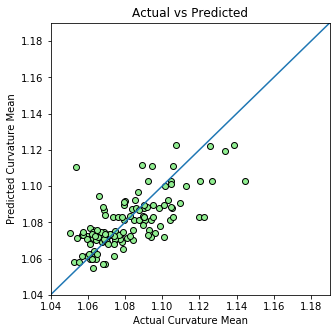

In [73]:
fig, ax = plt.subplots(figsize=(5, 5)) 
k_folds = KFold(n_splits = 5, random_state=0, shuffle=True)
mb_mae_all=[]
mb_rmse_all=[]
mb_r2_all=[]
for train_index, test_index in k_folds.split(feature):
    X_train, X_test = feature.iloc[train_index], feature.iloc[test_index]
    y_train, y_test = label_Curvature['Curvature_mean'].iloc[train_index],label_Curvature['Curvature_mean'].iloc[test_index]
    model1 = Ridge(alpha=6.0,solver='auto').fit(X_train, y_train)
    predictions=model1.predict(X_test)
    true = y_test
    mb_mae, mb_rmse,mb_r2 = evaluate_predictions(predictions, true)
    mb_mae_all.append(mb_mae)
    mb_rmse_all.append(mb_rmse)
    a4_dims = (10, 8)    
    ax.scatter(y_test,predictions, edgecolors=(0, 0, 0),color='lightgreen')

    ax.set_xlabel('Actual Curvature Mean')
    ax.set_ylabel('Predicted Curvature Mean')
    ax.set_title("Actual vs Predicted")

    plt.xlim((1.04,1.19))
    plt.ylim((1.04,1.19))
    x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
plt.show()

##  Features Importance Analysis

In [67]:
Bagging_logit =BaggingRegressor(RandomForestRegressor(n_estimators=20, max_depth=3 ,max_leaf_nodes=50), n_estimators=20)
Bagging_logit.fit(feature, label_Curvature['Curvature_mean'])
feature_importances = np.mean([
tree.feature_importances_ for tree in Bagging_logit.estimators_], axis=0)
varimp= {'Relative Variable Importance':feature_importances ,'Variable Names':features.columns}

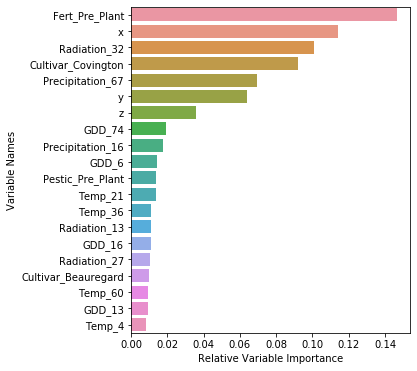

In [68]:
import seaborn as sns

a4_dims = (5, 6)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp)
df.sort_values(ascending=False,by=["Relative Variable Importance"],inplace=True)
df=df.dropna()
df=df.nlargest(20, 'Relative Variable Importance')
sns.barplot(x="Relative Variable Importance",y="Variable Names",data=df,orient="h",ax=ax);

In [69]:
ridge_logit =Ridge(alpha=6.0,solver='auto')
ridge_logit.fit(feature, label_Curvature)
varimp= {'Relative Variable Importance':np.abs(ridge_logit.coef_[0]) ,'Variable Names':features.columns}

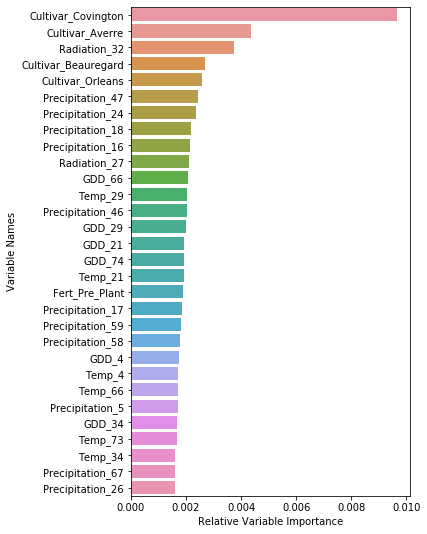

In [70]:
import seaborn as sns

a4_dims = (5, 9)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp)
df.sort_values(ascending=False,by=["Relative Variable Importance"],inplace=True)
df=df.dropna()
df=df.nlargest(30, 'Relative Variable Importance')
sns.barplot(x="Relative Variable Importance",y="Variable Names",data=df,orient="h",ax=ax);